In [1]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import six
# import pydot

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz

%matplotlib inline

# Column names from the word document "Network Anamoly Detection" for the dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dataset = pd.read_csv("../Data/Train.txt", names=column_names)
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [2]:
# Removing rows with no values in them
print("shape pre-dropna:", dataset.shape)
dataset.dropna(inplace=True)
print("shape post-dropna:", dataset.shape)

shape pre-dropna: (125973, 43)
shape post-dropna: (125973, 43)


In [3]:
# Giving the categories in the nominal features a separate column each with binarY/boolean values
temp = pd.get_dummies(dataset[['protocol_type', 'service', 'flag']]).astype('int')
# Replaces three features with eighty-four features boolean
print("Features created from 'protocol_type', 'service', and 'flag':", temp.shape)

# Getting the attack classes from the dataset
attack_classes = dataset.attack
attack_classes_dummy = pd.get_dummies(dataset['attack']).astype('int')

# Normal traffic is classified as 0, DOS is classified as 1, Probing is classified as 2, U2R is classified as 3 and R2L is classified as 4
def mapping(val):
    class_mapping = [
        ["normal"], # Normal traffic
        
        ["back", "land", "neptune", "pod", "smurf", "teardrop", "apache2",
         "udpstorm", "processtable", "worm"], # Denial of Service attack (DOS group)
        
        ["satan", "ipsweep", "nmap", "portsweep", "mscan", "saint"], # Surveilance attacks (Probing group)
        
        ["guess_passwd", "ftp_write", "imap", "phf", "multihop", "warezmaster",
         "warezclient", "spy", "xlock","xsnoop", "snmpguess", "snmpgetattack",
         "httptunnel", "sendmail", "named"], # Unauthorized access to root (U2R group)
        
        ["buffer_overflow", "loadmodule", "rootkit", "perl", "sqlattack",
         "xterm", "ps"] # Unauthorized access from a remote machine (R2L group)
        
    ]
    for index, class_map in enumerate(class_mapping):
        if val in class_map:
            return index
attack_classes_int = attack_classes.apply(mapping)

# Dropping the independent variable 'attack' and the columns 'protocol_type', 'service', and 'flag' 
temporary_dataset = dataset.drop(['attack', 'protocol_type', 'service', 'flag'], axis=1).astype('float64')
new_dataset = pd.concat([temporary_dataset, temp], axis=1)

print("New dataset's shape:", new_dataset.shape)
new_dataset.head()

Features created from 'protocol_type', 'service', and 'flag': (125973, 84)
New dataset's shape: (125973, 123)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


### Eliminating highly correlated features.

num_compromised and num_root are highly correlated (0.9988334525784719)
num_root and num_compromised are highly correlated (0.9988334525784719)
serror_rate and srv_serror_rate are highly correlated (0.9932892425370415)
serror_rate and dst_host_serror_rate are highly correlated (0.9793730829843228)
serror_rate and dst_host_srv_serror_rate are highly correlated (0.9811389586179857)
serror_rate and flag_S0 are highly correlated (0.9791740914923958)
srv_serror_rate and serror_rate are highly correlated (0.9932892425370415)
srv_serror_rate and dst_host_serror_rate are highly correlated (0.9775960119654394)
srv_serror_rate and dst_host_srv_serror_rate are highly correlated (0.9862517164930875)
srv_serror_rate and flag_S0 are highly correlated (0.9826599622600537)
rerror_rate and srv_rerror_rate are highly correlated (0.9890076529820739)
rerror_rate and dst_host_rerror_rate are highly correlated (0.9267485035759243)
rerror_rate and dst_host_srv_rerror_rate are highly correlated (0.96444866550

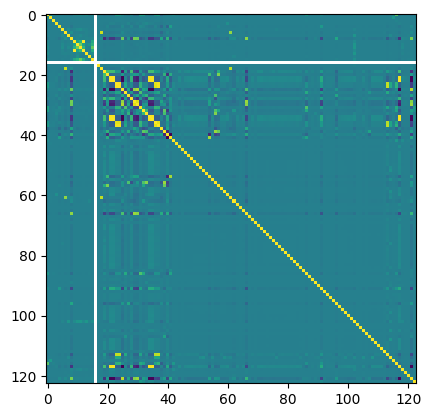

[[1.0, 0.07073682819085414, 0.03487779833437003, -0.0015532805525947443, -0.009865808515815139, 0.003829897181915918, 0.000705120566211187, 0.009528249936349882, -0.06421767647301116, 0.042679474817442095, 0.052790950792928525, 0.08718341292134439, 0.045519157361409816, 0.09911569750163096, -0.0015934673468352128, 0.07041992093460996, nan, -0.00025761943672739616, 0.0004402248819930365, -0.07904231889655419, -0.03947023790265667, -0.06987295957015192, -0.06951028293813129, 0.2006819844142431, 0.19996108167067075, 0.07468058598343401, -0.01373757895926031, -0.04015809532609311, 0.05057003428877992, -0.109775561199984, -0.11600495557790014, 0.2541951745852428, 0.2287373765622746, -0.026669376728929953, -0.06494796244229974, -0.06436051447487312, 0.1738152898998144, 0.19902360421159065, -0.15631061303783145, -0.029263345542364316, -0.004642982519098148, 0.027974374377361635, 0.09319418730832142, 0.0037412564778459014, -0.007744632866980154, -0.0004392939757158932, -0.008205440388428653, -

In [4]:
result = []
for columnx in new_dataset.columns:
    resulting_row = []
    for columny in new_dataset.columns:
        correlation = new_dataset[columnx].corr(new_dataset[columny])
        if (columnx != columny) and ((correlation > 0.9) or (correlation < -0.9)):
            print(f"{columnx} and {columny} are highly correlated ({correlation})")
        resulting_row.append(correlation)
    result.append(resulting_row)

plt.imshow(result)
plt.show()

print(result)

From the results above we can see that the following features are highly correlated:
* num_compromised and num_root
* serror_rate, srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, and flag_S0
* rerror_rate, srv_rerror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate

Therefore the remaining features will be (as the rest will be dropped):
* num_root
* serror_rate
* rerror_rate

In [5]:
# Dropping the features:
# num_compromised,
# srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, flag_S0,
# srv_rerror_rate, dst_host_rerror_rate, and dst_host_srv_rerror_rate 
print("pre:", new_dataset.shape)
features_droppping = ['num_compromised',
                      'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'flag_S0',
                      'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
new_dataset = new_dataset.drop(features_droppping, axis=1).astype('float64')
print("post:", new_dataset.shape)

pre: (125973, 123)
post: (125973, 115)


### Feature importance

In [6]:
dataset_train, dataset_test, value_train, value_test = train_test_split(new_dataset, attack_classes_int)

forest = RandomForestClassifier(random_state=0)
forest.fit(dataset_train, value_train)

RandomForestClassifier(random_state=0)

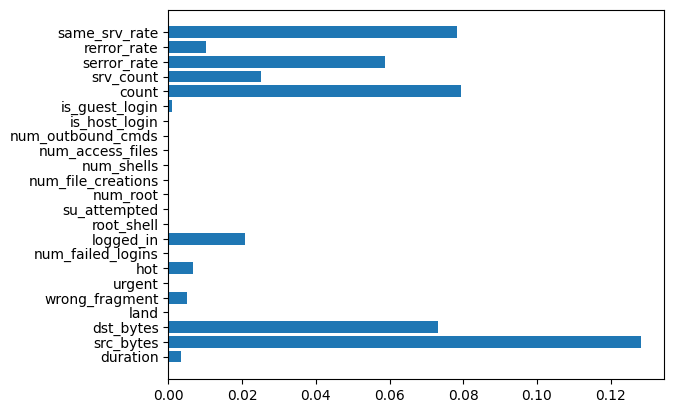

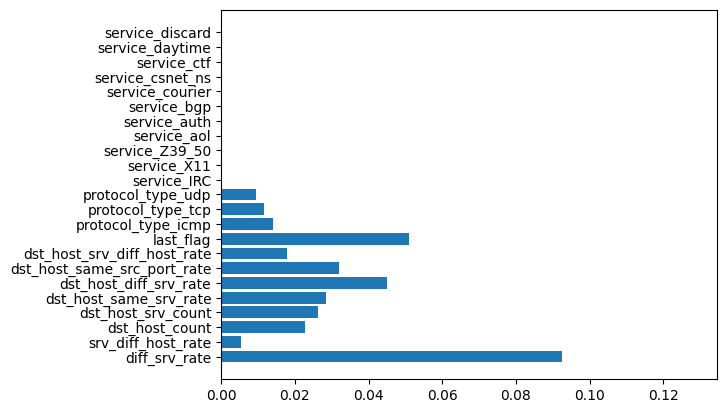

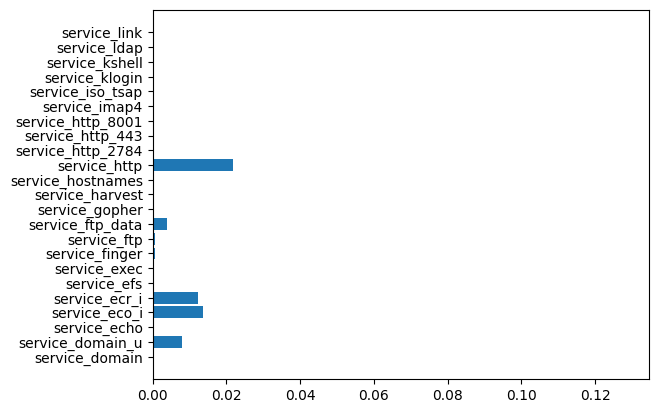

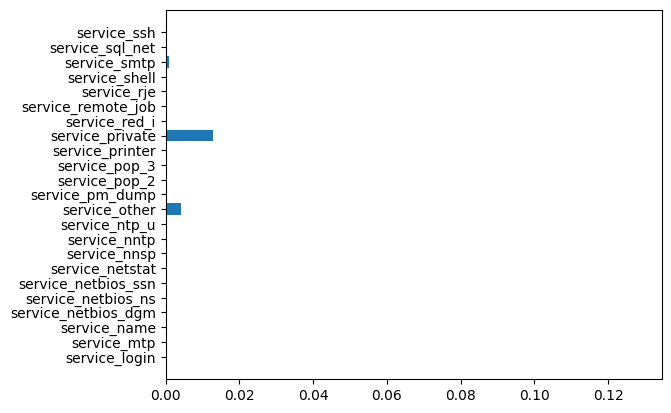

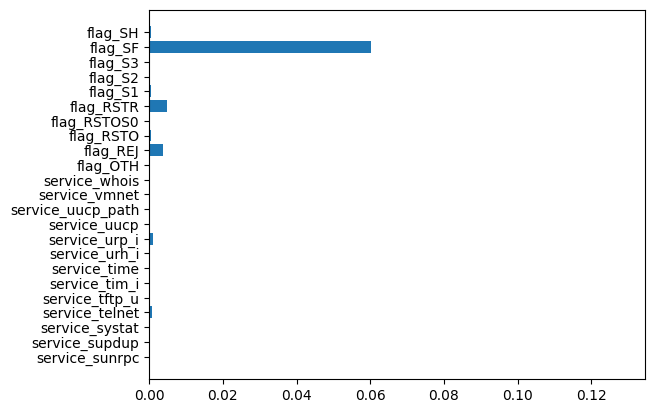

In [7]:
highest_value = max(forest.feature_importances_)
split_columns = np.array_split(new_dataset.columns, 5)
split_importances = np.array_split(forest.feature_importances_, 5)
for index in range(len(split_columns)):
    plt.barh(split_columns[index], split_importances[index])
    plt.xlim(0, highest_value + (highest_value*0.05))
    plt.show()


In [8]:
forest_importances = pd.Series(forest.feature_importances_, index=([x for x in dataset_train.columns]))
print("Number of important features:", len(forest_importances[forest_importances > 0.01]))
forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))
# protocol_type_tcp swapped out with service_eco_i

Number of important features: 23


src_bytes                      0.128146
diff_srv_rate                  0.092453
count                          0.079348
same_srv_rate                  0.078320
dst_bytes                      0.073142
flag_SF                        0.060177
serror_rate                    0.058874
last_flag                      0.050987
dst_host_diff_srv_rate         0.045116
dst_host_same_src_port_rate    0.031985
dst_host_same_srv_rate         0.028355
dst_host_srv_count             0.026161
srv_count                      0.025051
dst_host_count                 0.022651
service_http                   0.021831
logged_in                      0.020825
dst_host_srv_diff_host_rate    0.017993
protocol_type_icmp             0.014047
service_eco_i                  0.013579
service_private                0.012902
service_ecr_i                  0.012211
protocol_type_tcp              0.011687
rerror_rate                    0.010223
dtype: float64

In [9]:
# print(len(forest.estimators_))
# print(forest.estimators_)
# tree.plot_tree(forest.estimators_[0])

Correct predictions: 31473
Incorrect predictions: 21
Total samples: 31494
Accuracy score: 0.9993332063250143


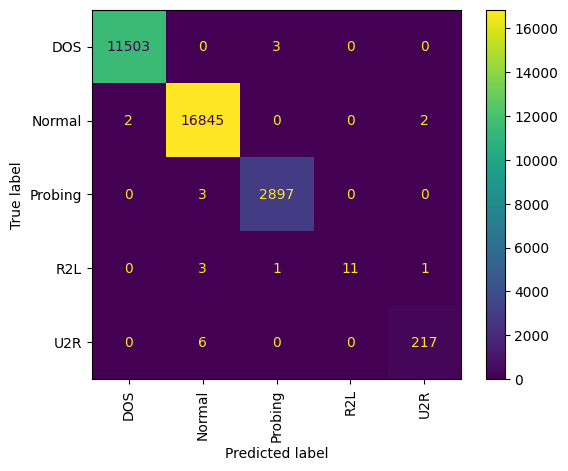

In [10]:
groups = ["Normal", "DOS", "Probing", "U2R", "R2L"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(groups[val])
for predicted_val in forest.predict(dataset_test):
    predicted_attacks.append(groups[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

# Correct predictions: 31480
# Incorrect predictions: 14
# Total samples: 31494
# Accuracy score: 0.9995554708833428

Making a new random forest model with the features having a variable importance over 0.01

In [11]:
important_features = forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))
new_forest = RandomForestClassifier(random_state=0)
new_forest.fit(dataset_train[important_features.index], value_train)



RandomForestClassifier(random_state=0)

In [12]:
# print(len(new_forest.estimators_))
# print(new_forest.estimators_)
# tree.plot_tree(new_forest.estimators_[0])
dotfile = six.StringIO()
iteration = 0
for estimator in new_forest.estimators_:
    if iteration < 1:
        export_graphviz(estimator, out_file="../Images/GroupForest.dot", feature_names=important_features.index, filled=True, rounded=True)
        with open("../Images/GroupForest.dot") as file:
            dot_graph = file.read()
        graphviz.Source(dot_graph)
    iteration += 1
    


In [13]:
scores = cross_val_score(new_forest, dataset_test, value_test, scoring="accuracy", cv=10)
print("Mean score:", np.mean(scores))
print("Max score:", np.max(scores))
print("Min score:", np.min(scores))
print("Standard deviation:", np.std(scores))
print("Standard variance:", np.var(scores))

Mean score: 0.9985711563761738
Max score: 0.9993648777389648
Min score: 0.9977770720863767
Standard deviation: 0.0005360392552780685
Standard variance: 2.8733808319906636e-07


Correct predictions: 31471
Incorrect predictions: 23
Total samples: 31494
Accuracy score: 0.9992697021654918


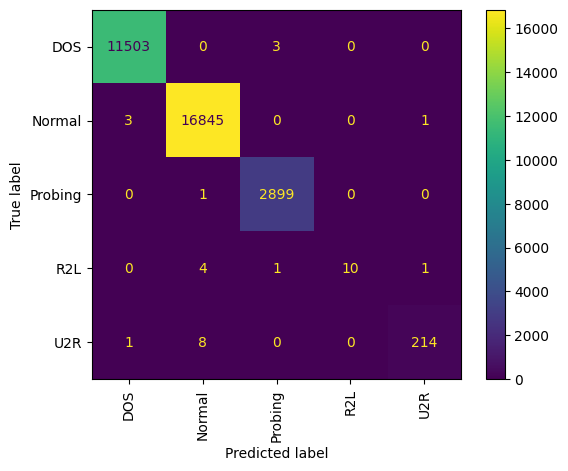

In [14]:
groups = ["Normal", "DOS", "Probing", "U2R", "R2L"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(groups[val])
for predicted_val in new_forest.predict(dataset_test[important_features.index]):
    predicted_attacks.append(groups[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

# Correct predictions: 31470
# Incorrect predictions: 24
# Total samples: 31494
# Accuracy score: 0.9992379500857306

Interesting observation splitting the attacks into groups i.e. normal, DOS, Probing, U2R and R2L improved the accuracy, additionally the model prefers other features.

### ROC curve

[1. 0. 1. ... 1. 0. 0.]
[0. 1. 0. ... 0. 1. 0.]


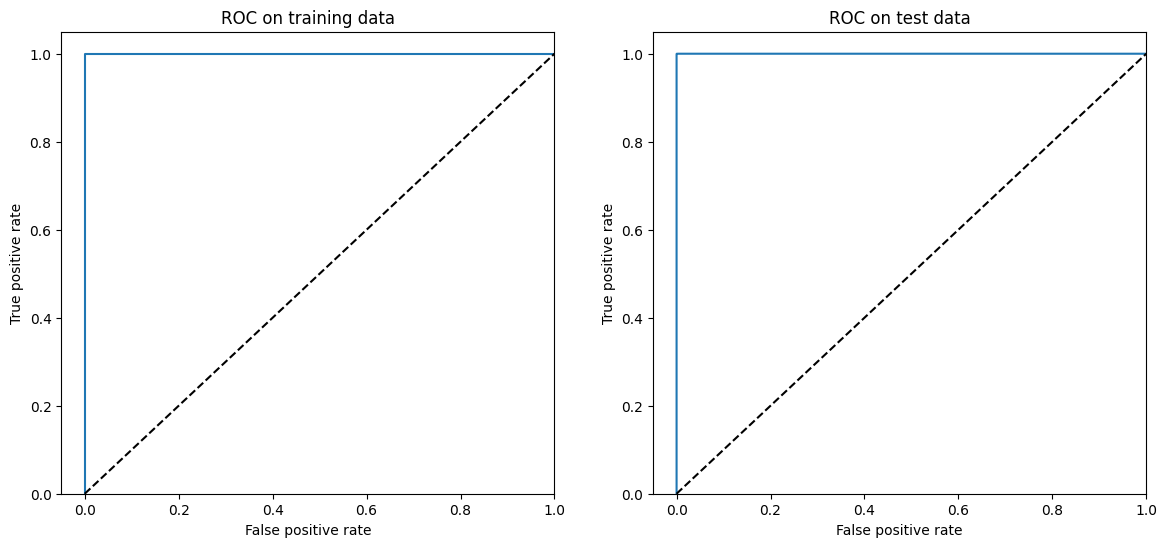

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
train_probability = new_forest.predict_proba(dataset_train[important_features.index])[:, 1]
test_probability = new_forest.predict_proba(dataset_test[important_features.index])[:, 1]

print(train_probability)
print(test_probability)
false_positive_rate_train, true_positive_rate_train, _ = roc_curve(value_train, train_probability, pos_label=1)
false_positive_rate_test, true_positive_rate_test, _ = roc_curve(value_test, test_probability, pos_label=1)



ax1.plot(false_positive_rate_train, true_positive_rate_train)
ax2.plot(false_positive_rate_test, true_positive_rate_test)
ax1.set_title("ROC on training data")
ax2.set_title("ROC on test data")

# plt.show()
for axises in fig.axes:
    axises.plot([0,1], [0,1], 'k--')
    axises.set_xlim([-0.05, 1])
    axises.set_ylim([0, 1.05])
    
    axises.set_xlabel("False positive rate")
    axises.set_ylabel("True positive rate")

In [16]:
# ax = plt.gca()
# # disp_train = RocCurveDisplay.from_estimator(new_forest, dataset_train, value_train, ax=ax, alpha=0.8)
# disp_test = RocCurveDisplay.from_estimator(new_forest, dataset_test, value_test, ax=ax, alpha=0.8)
# plt.show()

In [17]:
# test_probability = new_forest.predict_proba(dataset_test[important_features.index])[:, 1]
# false_positive_rate_test, true_positive_rate_test, threshold_test = roc_curve(value_test, test_probability, pos_label=1)
# print((value_test))
# roc_auc_test = roc_auc_score(value_test, test_probability)
# print(roc_auc_test)

In [18]:
sensitivity_dos = display.confusion_matrix[0][0] / np.sum(display.confusion_matrix[0][:])
sensitivity_normal = display.confusion_matrix[1][1] / np.sum(display.confusion_matrix[1][:])
sensitivity_probing = display.confusion_matrix[2][2] / np.sum(display.confusion_matrix[2][:])
sensitivity_r2l = display.confusion_matrix[3][3] / np.sum(display.confusion_matrix[3][:])
sensitivity_u2r = display.confusion_matrix[4][4] / np.sum(display.confusion_matrix[4][:])

print("Sensitivity DOS:", sensitivity_dos)
print("Sensitivity Normal:", sensitivity_normal)
print("Sensitivity Probing:", sensitivity_probing)
print("Sensitivity R2L:", sensitivity_r2l)
print("Sensitivity U2R:", sensitivity_u2r)

specificity_dos = np.sum(display.confusion_matrix[1:,1:]) / np.sum(display.confusion_matrix[0:,1:])
specificity_normal = (np.sum(display.confusion_matrix[1:, 0:1]) + np.sum(display.confusion_matrix[1:, 2:])) / (np.sum(display.confusion_matrix[0:, 0:1]) + np.sum(display.confusion_matrix[0:, 2:]))
specificity_probing = (np.sum(display.confusion_matrix[1:, 0:2]) + np.sum(display.confusion_matrix[1:, 3:])) / (np.sum(display.confusion_matrix[0:, 0:2]) + np.sum(display.confusion_matrix[0:, 3:]))
specificity_r2l = (np.sum(display.confusion_matrix[1:, 0:3]) + np.sum(display.confusion_matrix[1:, 4:])) / (np.sum(display.confusion_matrix[0:, 0:3]) + np.sum(display.confusion_matrix[0:, 4:]))
specificity_u2r = (np.sum(display.confusion_matrix[1:, 0:4]) + np.sum(display.confusion_matrix[1:, 5:])) / (np.sum(display.confusion_matrix[0:, 0:4]) + np.sum(display.confusion_matrix[0:, 5:]))

print("Specificity DOS:", specificity_dos)
print("Specificity Normal:", specificity_normal)
print("Specificity Probing:", specificity_probing)
print("Specificity R2L:", specificity_r2l)
print("Specificity U2R:", specificity_u2r)

# this is intrusion detection, use accuraxy and false positive rate!!!!

Sensitivity DOS: 0.999739266469668
Sensitivity Normal: 0.9997625971867766
Sensitivity Probing: 0.9996551724137931
Sensitivity R2L: 0.625
Sensitivity U2R: 0.9596412556053812
Specificity DOS: 0.9998499024365838
Specificity Normal: 0.21385624487564908
Specificity Probing: 0.5976705956419852
Specificity R2L: 0.6345445305552027
Specificity U2R: 0.6321376047061833


In [19]:
accuracies = []
for index in range(len(important_features.index)):
    temp_forest = RandomForestClassifier(random_state=0)
    temp_forest.fit(dataset_train[important_features.index[0:(index+1)]], value_train)
    scores = cross_val_score(temp_forest, dataset_test[important_features.index[0:(index+1)]], value_test, scoring="accuracy", cv=10)
    print("Mean score:", np.mean(scores))
    accuracies.append(np.mean(scores))
    
print(accuracies)
plt.plot(range(len(accuracies)+1), [0] + accuracies)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], labels=["src_bytes", "& diff_srv_rate", "& count", "& same_srv_rate", "& dst_bytes", "& serror_rate", 
 "& last_flag", "& flag_SF", "& dst_host_diff_srv_rate", "& dst_host_same_src_port_rate", "& dst_host_srv_count",
 "& dst_host_same_srv_rate", "& dst_host_count", "& srv_count", "& dst_host_srv_diff_host_rate", "& logged_in",
 "& service_private", "& protocol_type_icmp", "& service_eco_i", "& service_http", "& protocol_type_tcp",
 "& service_ecr_i", "& rerror_rate", ''], rotation="vertical")
plt.show()

In [20]:
print("False Positive Rate:", np.mean(false_positive_rate_test)*100)
print("F1-score:", np.mean(cross_val_score(new_forest, dataset_test[important_features.index], value_test, scoring="f1_macro", cv=10)))

False Positive Rate: 2.538732541850692


F1-score: 0.9175866753139331


### Test train split hyper parameter adjustment (20%, 25% (done above), 30%)

In [21]:
dataset_train_20, dataset_test_20, value_train_20, value_test_20 = train_test_split(new_dataset, attack_classes_int, test_size=0.20)
dataset_train_30, dataset_test_30, value_train_30, value_test_30 = train_test_split(new_dataset, attack_classes_int, test_size=0.30)
temp_forest_20 = RandomForestClassifier(random_state=0)
temp_forest_20.fit(dataset_train_20[important_features.index], value_train_20)
temp_forest_30 = RandomForestClassifier(random_state=0)
temp_forest_30.fit(dataset_train_30[important_features.index], value_train_30)

scores_20 = cross_val_score(temp_forest_20, dataset_test_20, value_test_20, scoring="accuracy", cv=10)
scores_30 = cross_val_score(temp_forest_30, dataset_test_30, value_test_30, scoring="accuracy", cv=10)
print("Cross validation accuracy (test size: 20%):", np.mean(scores_20))
print("Cross validation standard deviation (test size: 20%):", np.std(scores_20))
print("Cross validation variance (test size: 20%):", np.var(scores_20))

print("Cross validation accuracy (test size: 30%):", np.mean(scores_30))
print("Cross validation standard deviation (test size: 30%):", np.std(scores_30))
print("Cross validation variance (test size: 30%):", np.var(scores_30))

f1_score_20 = np.mean(cross_val_score(temp_forest_20, dataset_test_20, value_test_20, scoring="f1_macro", cv=10))
f1_score_30 = np.mean(cross_val_score(temp_forest_30, dataset_test_30, value_test_30, scoring="f1_macro", cv=10))
print("Cross validation f1-score (test size: 20%):", np.mean(f1_score_20))
print("Cross validation f1-score deviation (test size: 30%):", np.mean(f1_score_30))

confusion_matrix_20 = confusion_matrix(value_test_20, temp_forest_20.predict(dataset_test_20[important_features.index]))
confusion_matrix_30 = confusion_matrix(value_test_30, temp_forest_30.predict(dataset_test_30[important_features.index]))

correct_predictions = 0
for index in range(len(confusion_matrix_20)):
    correct_predictions += confusion_matrix_20[index][index]
print("Confusion matrix accuracy (test size: 20%):", correct_predictions/len(value_test_20))

correct_predictions = 0
for index in range(len(confusion_matrix_30)):
    correct_predictions += confusion_matrix_30[index][index]    
print("Confusion matrix accuracy (test size: 30%):", correct_predictions/len(value_test_30))

/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Cross validation accuracy (test size: 20%): 0.9980947654965122
Cross validation standard deviation (test size: 20%): 0.0007277196277836928
Cross validation variance (test size: 20%): 5.295758566616365e-07
Cross validation accuracy (test size: 30%): 0.9988357408177466
Cross validation standard deviation (test size: 30%): 0.0005821455179600875
Cross validation variance (test size: 30%): 3.3889340408101865e-07


/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Cross validation f1-score (test size: 20%): 0.9487503957908411
Cross validation f1-score deviation (test size: 30%): 0.8687714275135365
Confusion matrix accuracy (test size: 20%): 0.999047430045644
Confusion matrix accuracy (test size: 30%): 0.9993120237087214


: 